In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import io

from IO.IOUtil import merge_bin_coordinate
from Algorithm.distribution import *
from anndata import AnnData

In [3]:
image = io.imread("E:/data/RegionC/RegionCplaqueHires.png")

In [4]:
from Utils.utils import cut_image

cropped_image = cut_image(image)

<AxesSubplot:>

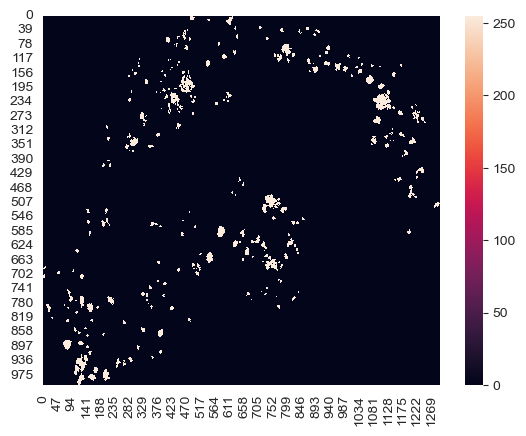

In [5]:
sns.heatmap(cropped_image)

In [6]:
cropped_image.shape

(1002, 1298)

In [7]:
# [index_col = 0] -> [Set the first column as row name]
raw_df = pd.read_csv("E:/data/brain10x.csv",
                     sep=',',
                     index_col=0)

In [36]:
APP23_1 = raw_df.filter(regex=r'^APP23_I_')
APP23_1 = APP23_1.rename(columns=lambda x: x.replace('APP23_I_', ''))
adata = AnnData(X=APP23_1.T)
position_df = pd.read_csv('E:/data/RegionC/RegionC_10x_immunoloc.csv', sep=',', index_col=0)
# relpace '-' to '.', example: 'AAACAAGTATCTCCCA-1' to 'AAACAAGTATCTCCCA.1'
position_df.index = position_df.index.str.replace('-', '.')
position_df.columns = position_df.columns.str.replace('pxl_row_in_immuno', 'x')
position_df.columns = position_df.columns.str.replace('pxl_col_in_immuno', 'y')
adata.obs = position_df.reindex(adata.obs.index)

In [37]:
adata.obs['x'] = merge_bin_coordinate(adata.obs['x'], adata.obs['x'].min(), bin_size=80)
adata.obs['y'] = merge_bin_coordinate(adata.obs['y'], adata.obs['y'].min(), bin_size=80)

In [15]:
get_exp_array(adata, adata.var.index[0]).shape

(81, 109)

In [17]:
from skimage import transform

resized = transform.resize(cropped_image, get_exp_array(adata, adata.var.index[0]).shape)

<AxesSubplot:>

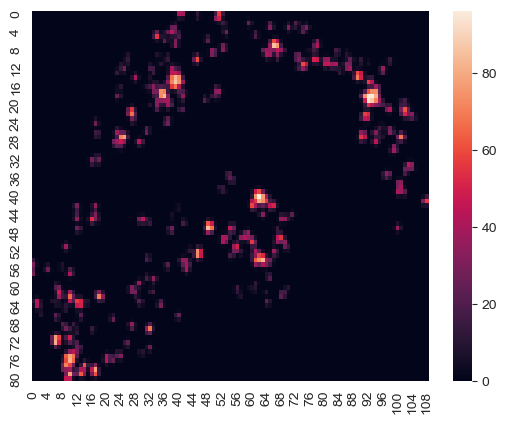

In [63]:
sns.heatmap(resized * 100)

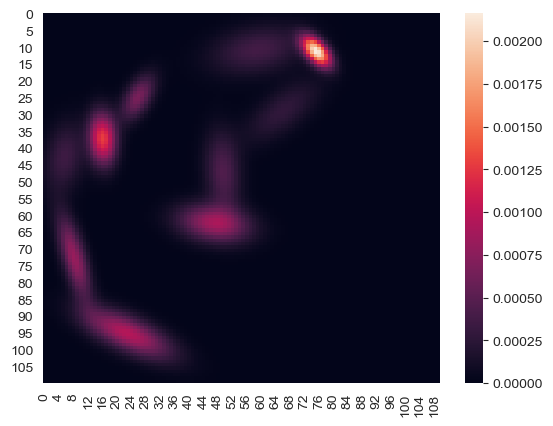

In [80]:
result = np.array(array_to_list(np.array(resized * 100, dtype=np.int32)))
gmm = mixture.GaussianMixture(n_components=10, max_iter=500)
gmm.fit(result)

start = 0
end = 110
num = end - start
x = np.linspace(start, end, num)
y = np.linspace(start, end, num)
x_range, y_range = np.meshgrid(x, y)
x_y = np.column_stack([x_range.flat, y_range.flat])
# calculate the density
density = gmm.score_samples(x_y)
density = density.reshape(x_range.shape)
sns.heatmap(np.exp(density))
plt.show()

In [81]:
gmm.means_

array([[26.09255969, 24.70828195],
       [23.24162002, 95.63821946],
       [59.59446201, 10.35965525],
       [49.83945147, 47.33647681],
       [ 5.57804061, 42.5311903 ],
       [ 8.22814279, 72.77706208],
       [66.53527996, 28.81610172],
       [16.21167016, 37.11513085],
       [76.00203662, 10.92331918],
       [47.40996104, 62.54488277]])

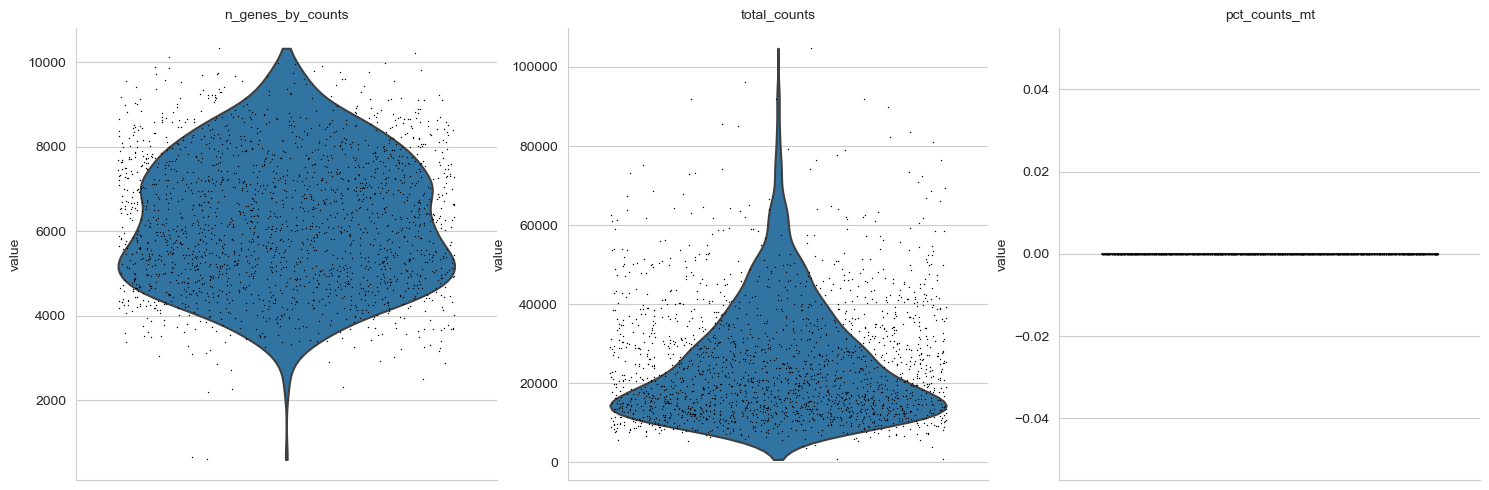

In [82]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [83]:
# Normalize genes count and log1p
sc.pp.normalize_total(adata, inplace=True, target_sum=1e4, exclude_highly_expressed=True)
# sc.pp.log1p(adata)
# # Select top variable genes
# sc.pp.highly_variable_genes(adata, n_top_genes=3000)

In [84]:
from skimage import morphology
from tqdm import tqdm

def filter_genes(adata):
    gene_list = list(adata.var.index)
    new_list = []
    for i in tqdm(gene_list, desc='Processing...'):
        matrix = get_exp_array(adata, i)
        eroded_image = morphology.erosion(matrix, np.ones((5, 5), dtype=np.bool_))
        if eroded_image.max() > 8:
            new_list.append(i)
    return new_list


gene_list = list(adata.var.index)
new_list = []
a = []
for i in tqdm(gene_list, desc='Processing...'):
    matrix = get_exp_array(adata, i)
    var = np.var(matrix, dtype=np.int32)
    a.append(var)
    if var > 7:
        new_list.append(i)



Processing...: 100%|██████████| 31054/31054 [01:51<00:00, 279.63it/s]


In [195]:
n = 0
for i in a:
    if i > 7:
        n+=1
print(n)

229


In [ ]:
sc.pp.highly_variable_genes

In [85]:
gmm_dict = fit_gmms(adata, new_list, n_comp=10, max_iter=200)

Fitting...: 100%|██████████| 229/229 [02:51<00:00,  1.33it/s]


In [90]:
def get_gmm_distance_array(gmm, gmm_dict, method='weight_match'):
    gene_list = list(gmm_dict.keys())
    gene_counts = len(gene_list)
    distance_dict = {}
    for gene in tqdm(range(gene_counts), desc='Building distance array...'):
            distance = distribution_distance(gmm, gmm_dict[gene_list[gene]], method=method)
            distance_dict[gene_list[gene]] = distance
    df = pd.DataFrame.from_dict(distance_dict, orient='index')
    sorted_df = df.sort_values(0)
    return sorted_df

df = get_gmm_distance_array(gmm, gmm_dict)

Building distance array...: 100%|██████████| 229/229 [00:00<00:00, 4489.56it/s]


In [91]:
df

,0
Tpi1,1.587344
Nptxr,1.653303
Ldhb,1.657644
Syn1,1.663044
Rtn1,1.667236
...,...
Ckb,1.983632
Rpl28,1.983743
Stmn1,1.984836
hAPP,1.985399


In [198]:
from Algorithm.graph import build_gmm_distance_array

arr = build_gmm_distance_array(gmm_dict, method='optimized_match')

Building distance array...: 100%|██████████| 229/229 [00:40<00:00,  5.70it/s]


F:\conda\envs\spatial\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
F:\conda\envs\spatial\lib\site-packages\seaborn\matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


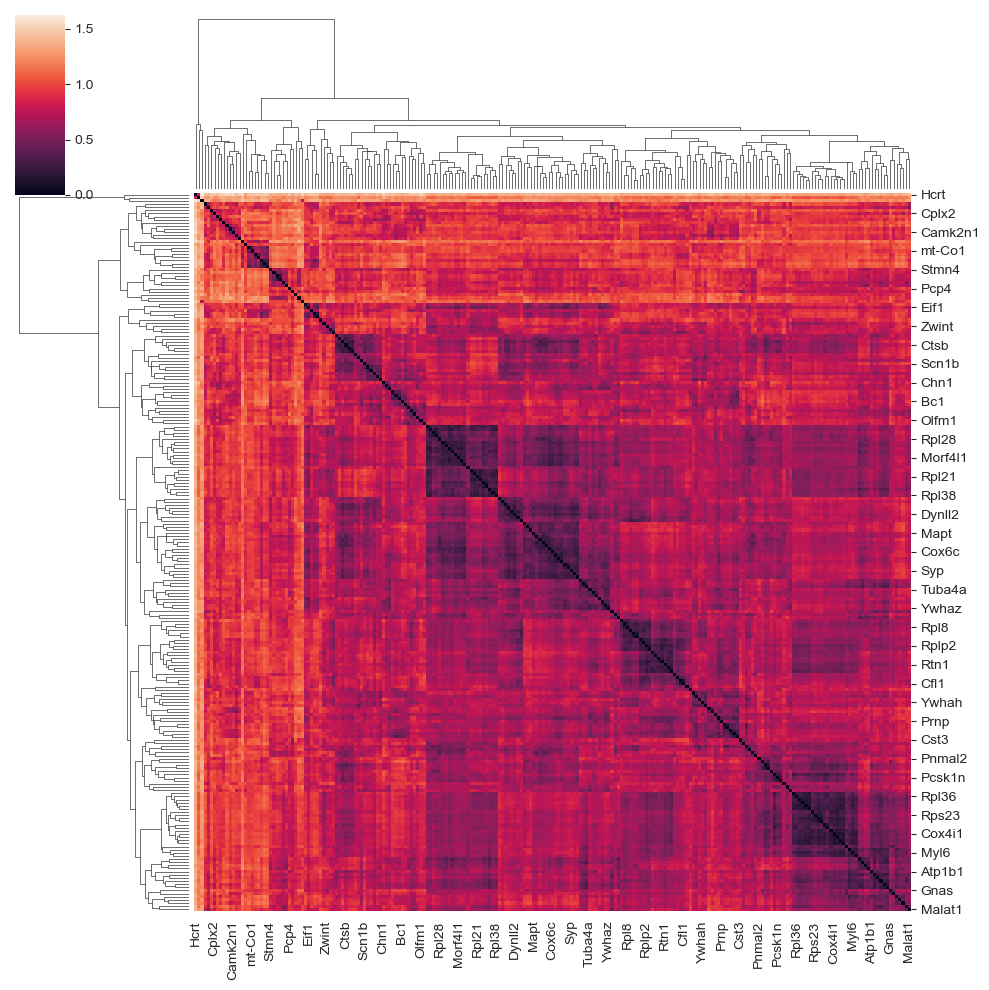

In [199]:
sns.clustermap(arr)

In [299]:
result = cluster(arr, mds_components=20, n_clusters=11)

F:\conda\envs\spatial\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
F:\conda\envs\spatial\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


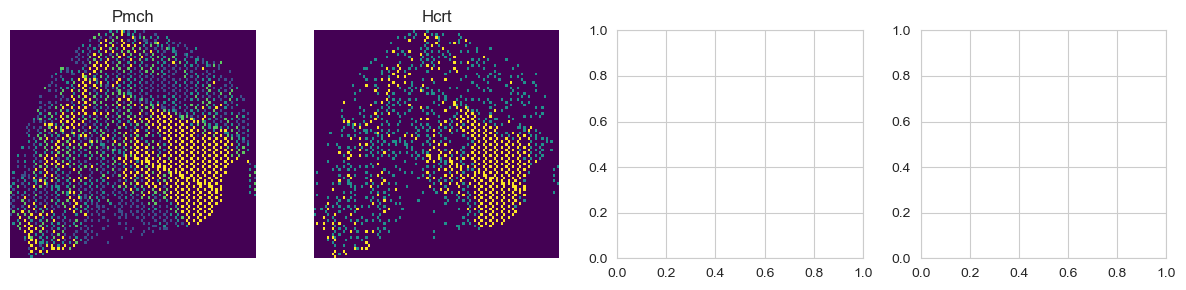

In [328]:
from Utils.plot import plot_heatmap

plot_heatmap(result,
             adata,
             label=10,
             vmax=95,
             num_cols=4,
             cmap='viridis'
             )

<AxesSubplot:>

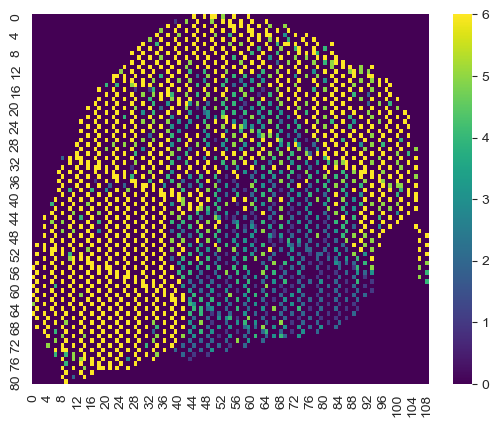

In [212]:
a = get_exp_array(adata,'Tcf4')
sns.heatmap(a, cmap='viridis', vmax=np.percentile(a, 90))

In [1]:
def plot_pattern(result, adata, label, cmap=None, vmax=99):
    li = list(result[result['labels'] == label]['gene_id'])
    total = np.zeros(get_exp_array(adata, li[0]).shape)
    for i in li:
        total += get_exp_array(adata, i)
    if cmap is not None:
        sns.heatmap(total, cmap=cmap, vmax=np.percentile(total, vmax))
    else:
        sns.heatmap(total, vmax=np.percentile(total, vmax))

plot_pattern(result, adata, label=10, cmap='viridis', vmax=95)

NameError: name 'result' is not defined

<AxesSubplot:>

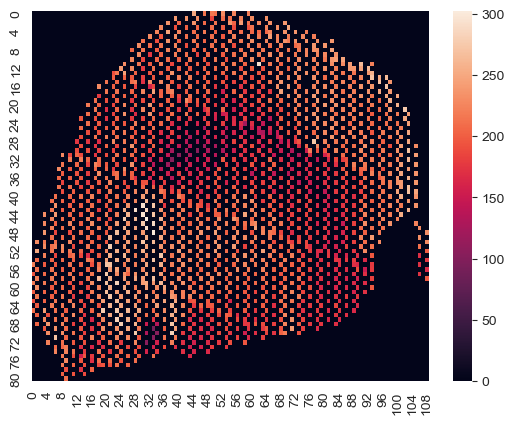

In [272]:
sns.heatmap(total)

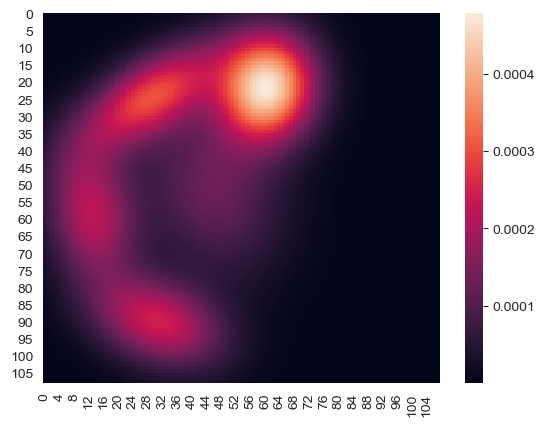

In [213]:
gmm = fit_gmm(adata, 'Tcf4', n_comp=5)
view_gmm(gmm, scope=(0, max(adata.obs['y'].max(), adata.obs['x'].max())))

C:\Users\pssun\AppData\Local\Temp\ipykernel_29208\1523502273.py:9: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='average')


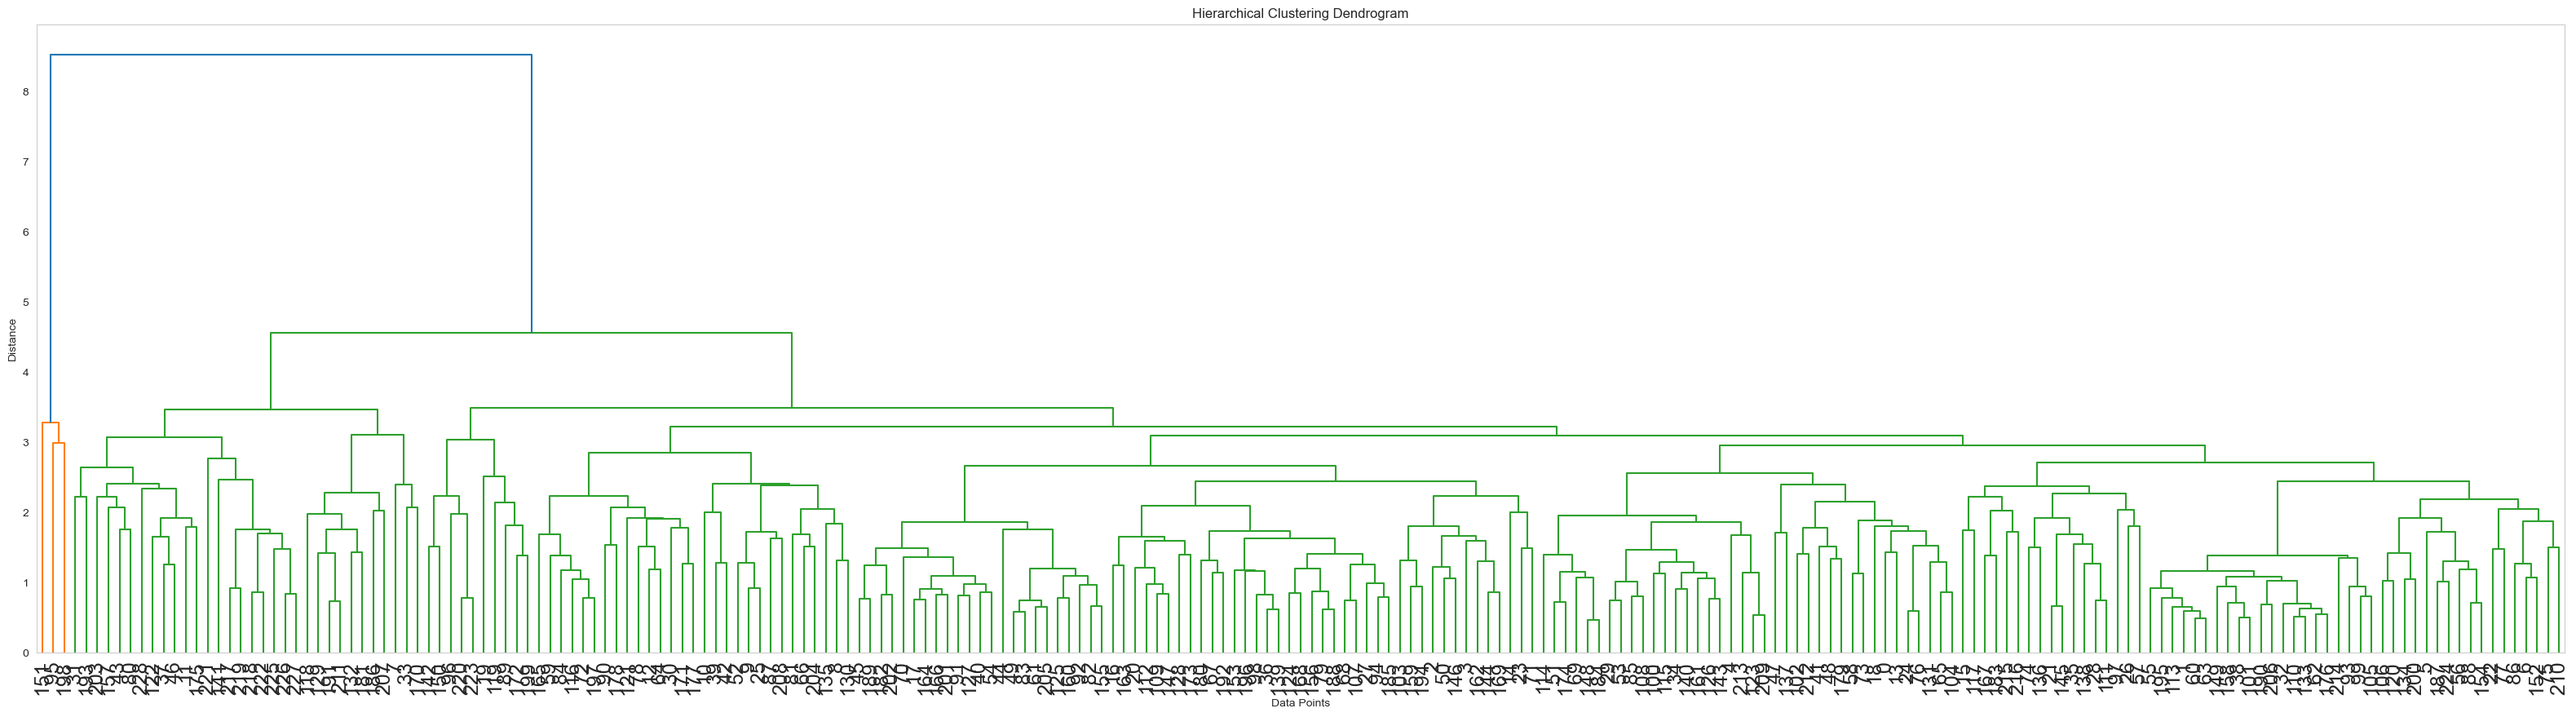

In [235]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# 示例距离矩阵
distance_matrix = arr

# 层次聚类
Z = linkage(distance_matrix, method='average')

# 绘制树状图（谱系聚类图）
plt.figure(figsize=(40, 10))
dendrogram(Z)
plt.xticks(fontsize=18)
plt.grid(False)  # 去掉网格线
# 设置图形标题和坐标轴标签
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')

# 显示图形
plt.show()